In [ ]:
#!wget http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
#!tar xvf simple-examples.tgz

In [ ]:
"""Utilities for parsing PTB text files."""
from __future__ import absolute_import
from __future__ import print_function

import collections
import os
import sys
import time

import tensorflow.python.platform

import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
from tensorflow.models.rnn import rnn

from tensorflow.python.platform import gfile


def _read_words(filename):
  with gfile.GFile(filename, "r") as f:
    return f.read().replace("\n", "<eos>").split()


def _build_vocab(filename):
  data = _read_words(filename)

  counter = collections.Counter(data)
  count_pairs = sorted(counter.items(), key=lambda x: -x[1])

  words, _ = list(zip(*count_pairs))
  word_to_id = dict(zip(words, range(len(words))))

  return word_to_id


def _file_to_word_ids(filename, word_to_id):
  data = _read_words(filename)
  return [word_to_id[word] for word in data]


def ptb_raw_data():
  """Load PTB raw data from data directory "data_path".
  Reads PTB text files, converts strings to integer ids,
  and performs mini-batching of the inputs.
  The PTB dataset comes from Tomas Mikolov's webpage:
  http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
  Args:
    data_path: string path to the directory where simple-examples.tgz has
      been extracted.
  Returns:
    tuple (train_data, valid_data, test_data, vocabulary)
    where each of the data objects can be passed to PTBIterator.
  """

  train_path = os.path.join('./simple-examples/data/', "ptb.train.txt")
  valid_path = os.path.join('./simple-examples/data/', "ptb.valid.txt")
  test_path = os.path.join('./simple-examples/data', "ptb.test.txt")

  word_to_id = _build_vocab(train_path)
  train_data = _file_to_word_ids(train_path, word_to_id)
  valid_data = _file_to_word_ids(valid_path, word_to_id)
  test_data = _file_to_word_ids(test_path, word_to_id)
  vocabulary = len(word_to_id)
  return train_data, valid_data, test_data, vocabulary


def ptb_iterator(raw_data, batch_size, num_steps):
  """Iterate on the raw PTB data.
  This generates batch_size pointers into the raw PTB data, and allows
  minibatch iteration along these pointers.
  Args:
    raw_data: one of the raw data outputs from ptb_raw_data.
    batch_size: int, the batch size.
    num_steps: int, the number of unrolls.
  Yields:
    Pairs of the batched data, each a matrix of shape [batch_size, num_steps].
    The second element of the tuple is the same data time-shifted to the
    right by one.
  Raises:
    ValueError: if batch_size or num_steps are too high.
  """
  raw_data = np.array(raw_data, dtype=np.int32)

  data_len = len(raw_data)
  batch_len = data_len // batch_size
  data = np.zeros([batch_size, batch_len], dtype=np.int32)
  for i in range(batch_size):
    data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

  epoch_size = (batch_len - 1) // num_steps

  if epoch_size == 0:
    raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

  for i in range(epoch_size):
    x = data[:, i*num_steps:(i+1)*num_steps]
    y = data[:, i*num_steps+1:(i+1)*num_steps+1]
    yield (x, y)

In [ ]:
import tensorflow as tf
from tensorflow.models.rnn import rnn
from tensorflow.models.rnn import rnn_cell
from tensorflow.models.rnn import seq2seq

In [ ]:
init_scale = 0.1
learning_rate = 1.0
max_grad_norm = 5
num_layers = 5
num_steps = 20
hidden_size = 200
max_epoch = 4
max_max_epoch = 13
keep_prob = 0.5
lr_decay = 0.5
batch_size = 20
vocab_size = 10000

In [ ]:
with tf.Graph().as_default(), tf.Session() as session:

  input_data = tf.placeholder(tf.int32, [batch_size, num_steps])
  targets = tf.placeholder(tf.int32, [batch_size, num_steps])

  lstm_cell = rnn_cell.BasicLSTMCell(hidden_size, forget_bias=0.0)
  lstm_cell = rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
  cell = rnn_cell.MultiRNNCell([lstm_cell] * num_layers)

  initial_state = cell.zero_state(batch_size, tf.float32)

  initializer = tf.random_uniform_initializer(-init_scale, init_scale)

  embedding = tf.get_variable("embedding", [vocab_size, hidden_size], initializer=initializer)      
  
  inputs_tmp1 = tf.nn.embedding_lookup(embedding, input_data) # [20][20][200]
  inputs_tmp2 = tf.nn.dropout(inputs_tmp1, keep_prob) # [20][20][200]
  inputs = [tf.squeeze(input_, [1]) for input_ in tf.split(1, num_steps, inputs_tmp2)] # (list of 20)[20][200]
    
  outputs, states = rnn.rnn(cell, inputs, initial_state=initial_state)
  
  output = tf.reshape(tf.concat(1, outputs), [-1, hidden_size])
  logits = tf.nn.xw_plus_b(output,
                           tf.get_variable("softmax_w", [hidden_size, vocab_size]),
                           tf.get_variable("softmax_b", [vocab_size]))
  loss = seq2seq.sequence_loss_by_example([logits],
                                          [tf.reshape(targets, [-1])],
                                          [tf.ones([batch_size * num_steps])],
                                          vocab_size)
  cost = tf.reduce_sum(loss) / batch_size
  final_state = states[-1]
  
  lr = tf.Variable(0.0, trainable=False) # trainable defaults to True..!
  tvars = tf.trainable_variables()
  grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), max_grad_norm)
  optimizer = tf.train.GradientDescentOptimizer(lr)
  train_op = optimizer.apply_gradients(zip(grads, tvars))
  
  session.run(tf.initialize_all_variables())
  
  raw_data = ptb_raw_data()
  train_data, valid_data, test_data, _ = raw_data
  
  for i in range(max_max_epoch):
    
    lr_decay = lr_decay ** max(i - max_epoch, 0.0)
    session.run(tf.assign(lr, learning_rate * lr_decay))
    
    epoch_size = ((len(train_data) // batch_size) - 1) // num_steps
    start_time = time.time()
    costs = 0.0
    iters = 0
    loop_state = initial_state.eval()

    for step, (x, y) in enumerate(ptb_iterator(train_data, batch_size, num_steps)):
  
      ret1, ret2, ret3, ret4, ret5, ret6, ret7, loop_cost, loop_state, _ = session.run([inputs_tmp1, 
                                embedding,
                                inputs_tmp2,
                                inputs[0],
                                outputs[0],
                                output,
                                logits,
                                cost, final_state, train_op],
                 {input_data: x,
                  targets: y,
                  initial_state: loop_state})
    
      for v in tvars:
        print(v.name)
      
      break

      '''loop_cost, loop_state, _ = session.run([cost, final_state, train_op],
                                   {input_data: x,
                                    targets: y,
                                    initial_state: loop_state})

      costs += loop_cost
      iters += num_steps

      if step % (epoch_size // 10) == 10:
        print("%.3f perplexity: %.3f speed: %.0f wps" %
              (step * 1.0 / epoch_size, np.exp(costs / iters),
               iters * batch_size / (time.time() - start_time)))

    perplexity = np.exp(costs / iters)'''
      
    break

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
ret1.shape

In [ ]:
ret3.shape

In [ ]:
ret4.shape

In [ ]:
ret5.shape

In [ ]:
ret6.shape

In [ ]:
ret6

In [ ]:
len(outputs)

In [ ]:
ret7.shape

In [ ]:
ret7[0]

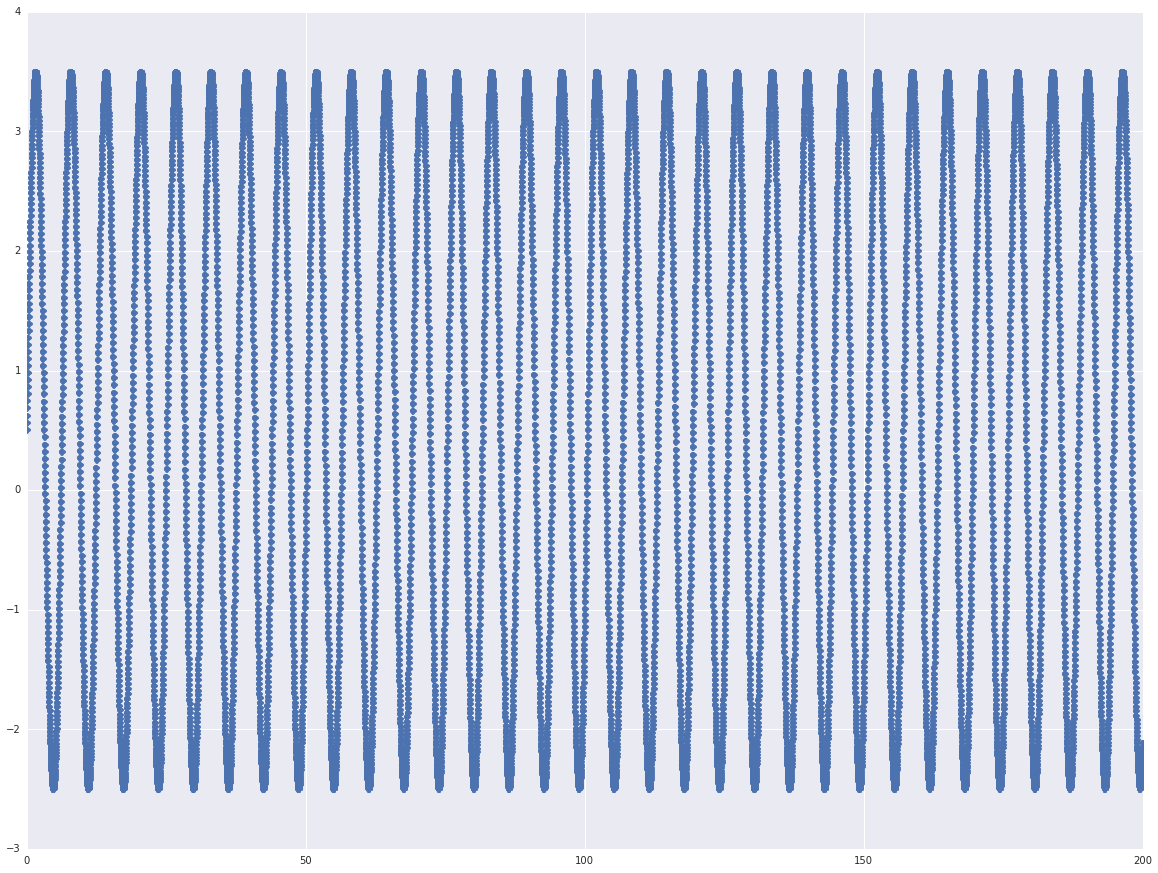

In [1]:
import numpy as np
from scipy.optimize import leastsq
import pylab as plt

N = 10000
t = np.linspace(0, 200, N)
#data = 3.0*np.sin(t+0.001) + 0.5 + np.random.randn(N)
train_data = 3.0*np.sin(t+0.001) + 0.5

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)
plt.plot(t, train_data, 'o')
plt.show()

If we start to think about applying this to financial time series...
What should be the inputs..?
And what should be the outputs..?

Inputs:
* A tensor of each index from day N.  E.g. [1.23, 2.34, 3.45, 4.56, 5.67, 6.78, 7.89, 8.90]

In [2]:
import tensorflow as tf
from tensorflow.models.rnn import rnn
from tensorflow.models.rnn import rnn_cell
from tensorflow.models.rnn import seq2seq
import time

In [3]:
def data_iterator(raw_data, batch_size, num_steps):
  
  raw_data = np.array(raw_data, dtype=np.float32)
  
  batch_len = len(raw_data) // batch_size
  
  data = np.zeros([batch_size, batch_len], dtype=np.float32)
  for i in range(batch_size):
    data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

  epoch_size = (batch_len - 1) // num_steps

  if epoch_size == 0:
    raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

  for i in range(epoch_size):
    x = data[:, i*num_steps:(i+1)*num_steps]
    y = data[:, i*num_steps+1:(i+1)*num_steps+1]
    yield (x, y)

In [4]:
batch_size = 10
num_steps = 10
hidden_size = 100
num_hidden_layers = 2
keep_prob = 0.5
max_grad_norm = 5
max_epoch = 2
lr_decay = 0.5
learning_rate = 1.0

In [5]:
#session = tf.InteractiveSession()

In [22]:
with tf.Graph().as_default(), tf.Session() as session:

  x = tf.placeholder(tf.float32, [batch_size, num_steps]) # [10][10]
  y = tf.placeholder(tf.float32, [batch_size, num_steps]) # [10][10]

  lstm_cell = rnn_cell.BasicLSTMCell(hidden_size, forget_bias=0.0)
  lstm_cell = rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
  cell = rnn_cell.MultiRNNCell([lstm_cell] * num_hidden_layers)

  initial_state = cell.zero_state(batch_size, tf.float32) # [10][?]

  inputs = tf.split(1, num_steps, x) # (list:10)[10][1]

  outputs, states = rnn.rnn(cell, inputs, initial_state=initial_state) # outputs (list:10)[10][100]

  output = tf.concat(0, outputs) # [100][100]
  y_ = \
    tf.matmul(output, tf.get_variable("softmax_w", [hidden_size, batch_size])) \
    + tf.get_variable("softmax_b", [batch_size]) # [100][10]

  #loss = -tf.reduce_sum(y*tf.log(y_))
  '''final_state = states[-1]

  lr = tf.Variable(0.0, trainable=False)
  tvars = tf.trainable_variables()
  grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), max_grad_norm)
  optimizer = tf.train.GradientDescentOptimizer(lr)
  train_op = optimizer.apply_gradients(zip(grads, tvars))'''

  session.run(tf.initialize_all_variables())

  for i in range(max_epoch):

    '''lr_decay = lr_decay ** max(i - max_epoch, 0.0)
    session.run(tf.assign(lr, learning_rate * lr_decay))'''

    epoch_size = ((len(train_data) // batch_size) - 1) // num_steps
    start_time = time.time()
    costs = 0.0
    iters = 0
    loop_state = initial_state.eval()

    for step, (xx, yy) in enumerate((data_iterator(train_data, batch_size, num_steps))):

      res1, res2, res3, y__res = session.run([output, outputs[0], inputs[0], y_],
                         {x: xx,
                          y: yy,
                          initial_state: loop_state})

In [7]:
tmp1 = np.array(res1)

In [8]:
tmp1.shape

(100, 100)

In [9]:
len(outputs)

10

In [10]:
tmp2 = np.array(res2)

In [11]:
tmp2.shape

(10, 100)

In [12]:
len(inputs)

10

In [13]:
tmp3 = np.array(res3)

In [14]:
res3.shape

(10, 1)

In [19]:
y__res.shape

(100, 10)